# **Дилемма смещения и разброса. Полиномиальные признаки. Регуляризация**

In [1]:
from sklearn import metrics
from sklearn import preprocessing
# всё остальное
from sklearn import linear_model
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
from IPython.display import display
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
%matplotlib inline
plt.style.use('seaborn') #установка стиля matplotlib

from sklearn.datasets import load_boston 

## **СМЕЩЕНИЕ И РАЗБРОС**

Центральной проблемой всего обучения с учителем (не только линейных моделей) является ***дилемма смещения и разброса модели***. Давайте узнаем, что это такое.

До этого момента мы обучали модели на всех имеющихся данных. С одной стороны, это имеет смысл, ведь мы хотим минимизировать ошибки модели, используя как можно больше данных для обучения.

С другой стороны, из-за такого подхода становится труднее оценивать, насколько хорошо работает модель. Причина этого в том, что, если мы продолжим рассчитывать метрики, используя тренировочные данные, мы можем обнаружить, что при применении модели на незнакомых ей данных она работает довольно плохо.

*Таким образом, модель может детально подстроиться под зависимость в обучающей выборке, но не уловить общей сути.*

Такая проблема называется **переобучением** (overfitting). По сути, такая модель работает намного лучше с обучающими данными, чем с новыми. Она была чрезмерно натренирована на обнаружение уникальных характеристик обучающего набора данных, которые не являются общими закономерностями.

**Недообучение** (underfitting) — проблема, обратная переобучению. Модель из-за своей слабости не уловила никаких закономерностей в данных. В этом случае ошибка будет высокой как для тренировочных данных, так и для данных, не показанных во время обучения.

![](https://lms.skillfactory.ru/assets/courseware/v1/24d0e131092f71d843db3a5fe85cdbf5/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/dst3-ml2-5_1.png)

* На первом рисунке изображена простая модель линейной регрессии, не способная уловить сложную зависимость в данных.
* На втором рисунке изображена оптимальная модель, которая хорошо описывает зависимость и при этом не имеет переобучения (полином четвёртой степени).
* На последнем рисунке изображен полином 27-й степени, который подстроился под каждую точку в тренировочном наборе, но не смог уловить общие закономерности.
***
С теоретической точки зрения недообучение и переобучение характеризуются понятиями **смещения** и **разброса** модели.
***
**Смещение (bias)** — это математическое ожидание разности между истинным ответом и ответом, выданным моделью. То есть это **ожидаемая ошибка модели**.

![](data\f49.png)

В зарубежной литературе математическое ожидание часто обозначается как ***E***:

![](data\f50.png)

Чем больше смещение, тем слабее модель. Если модель слабая, она не в состоянии выучить закономерность. Таким образом, налицо недообучение модели.
***
**Разброс (variance)** — это вариативность ошибки, то, насколько ошибка будет отличаться, если обучать модель на разных наборах данных. Математически это дисперсия (разброс) ответов модели.

![](data\f51.png)

Примечание. В зарубежной литературе дисперсия часто обозначается как ***Var***:

![](data\f52.png)

Чем больше разброс, тем больше ошибка будет колебаться на разных наборах данных. Наличие высокого разброса и есть свидетельство переобучения: модель подстроилась под конкретный набор данных и даёт высокий разброс ответов на разных данных.
***
Теоретически на составляющие смещения и разброса модели можно разложить любую функцию потерь. Например, разложение квадратичной ошибки (её математическое ожидание) будет выглядеть следующим образом:

![](data\f53.png)

Математическое ожидание — это среднее значение во всей генеральной совокупности (на бесконечной выборке), а не на конкретных значениях. Это исключительно теоретическая величина.

* ***σ*** — неустранимая ошибка, вызванная случайностью.
* ***bias(y)^2*** — смещение модели (в квадрате).
* ***variance(y)*** — разброс модели.

**О чём нам говорит эта теоретическая формула?**

Ошибка модели складывается из смещения модели (в квадрате) и её разброса, а также случайной ошибки. 

Если с последним слагаемым  мы ничего не сможем сделать, то вот на первые два (bias и variance) мы можем как-то повлиять. В идеале мы должны свести их к 0. Однако уменьшение одного слагаемого повлечёт увеличение другого. На практике часто приходится балансировать между смещёнными и нестабильными оценками.
Дилемма смещения-дисперсии является центральной проблемой в обучении с учителем. В идеале мы хотим построить модель, которая точно описывает зависимости в тренировочных данных и хорошо работает на неизвестных данных. К сожалению, обычно это невозможно сделать одновременно.

* **Усложняя** модель, мы пытаемся **уменьшить смещение (bias)**, однако появляется риск получить переобучение, то есть мы **повышаем разброс (variance)**. 
* С другой стороны, **снизить разброс (variance)** позволяют более **простые модели**, не склонные к переобучению, но есть риск, что простая модель не уловит зависимостей и окажется недообученной, то есть мы **повышаем смещение (bias)**.

Если провести аналогию, что модель — это игрок в дартс, то самый лучший игрок будет иметь небольшое смещение и разброс: его дротики ложатся кучно «в яблочко». Если у игрока большое смещение, то дротики сгруппированы около другой точки, а если большой разброс — дротики разлетаются по всей мишени.

![](https://lms.skillfactory.ru/assets/courseware/v1/c9e31e930c613a02ef6abd7c363158d6/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/dst3-ml2-5_2.png)
***
Теперь, когда мы знаем о теоретических основах проблемы переобучения и недообучения, что мы можем сделать, чтобы лучше судить о способности модели к обобщению на практике? Как диагностировать высокие bias и variance?

Типичным решением является разделение данных на две части: **обучающий** и **тестовый** наборы. На тренировочном наборе данных мы будем обучать модель, подбирая параметры. Тестовый набор данных, который модель не видела при обучении, мы будем использовать для оценки истинного качества моделирования. Схематично можно представить это следующим образом:

![](https://lms.skillfactory.ru/assets/courseware/v1/6b3371e3f1d290f0c216ac1e826005ff/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/dst3-ml2-5_3.png)



Давайте посмотрим, как это работает на практике. Работать будем с уже знакомыми нам данными — данными о домах в Бостоне.

In [2]:
from sklearn.datasets import load_boston 

boston = load_boston()
#создаём DataFrame из загруженных numpy-матриц
boston_data = pd.DataFrame(
    data=boston.data, #данные
    columns=boston.feature_names #наименования столбцов
)
#добавляем в таблицу столбец с целевой переменной
boston_data['MEDV'] = boston.target
 
#Составляем список факторов (исключили целевой столбец)
features = boston_data.drop('MEDV', axis=1).columns
#Составляем матрицу наблюдений X и вектор ответов y
X = boston_data[features]
y = boston_data['MEDV']

c:\Users\local_admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets inclu

В **sklearn** для разделения выборки на тренировочную и тестовую есть функция [**train_test_split()**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) из модуля **model_selection**. Данная функция принимает следующие аргументы:

* ***X*** и ***y*** — таблица с примерами и ответами к ним.
* ***random_state*** — число, на основе которого генерируются случайные числа. Тренировочная и тестовая выборка генерируются случайно. Чтобы эксперимент был воспроизводимым, необходимо установить этот параметр в конкретное значение.
* ***test_size*** — доля тестовой выборки. Параметр определяет, в каких пропорциях будет разделена выборка. Стандартные значения: 70/30, 80/20.

Функция возвращает четыре объекта в следующем порядке: тренировочные примеры, тестовые примеры, тренировочные ответы и тестовые ответы. 

Итак, давайте разделим нашу выборку на тренировочную и тестовую в соотношении 70/30:

In [3]:
from sklearn.model_selection import train_test_split
#Разделяем выборку на тренировочную и тестовую в соотношении 70/30
#Устанавливаем random_state для воспроизводимости результатов 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)
#Выводим результирующие размеры таблиц
print('Train:', X_train.shape, y_train.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (354, 13) (354,)
Test: (152, 13) (152,)


После разделения в тренировочной выборке оказались 354 наблюдения, а в тестовой — 152.

Затем обучим линейную регрессию (с помощью МНК) на тренировочных данных и рассчитаем R^2 для тренировочных и тестовых данных:

In [4]:
#Создаём объект класса LinearRegression
lr_model = linear_model.LinearRegression()
#Обучаем модель по МНК
lr_model.fit(X_train, y_train)
 
#Делаем предсказание для тренировочной выборки
y_train_predict = lr_model.predict(X_train)
#Делаем предсказание для тестовой выборки
y_test_predict = lr_model.predict(X_test)
 
print("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_train_predict)))
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_test_predict)))

Train R^2: 0.743
Test R^2: 0.722


Итак, ***R^2 = 0.743*** на тренировочной выборке и ***R^2 = 0.722*** на тестовой выборке. То есть показатели довольно близки друг к другу (низкий разброс ответов модели для разных выборок).

Это одно из свидетельств отсутствия переобучения. Это не удивительно, ведь линейная регрессия, построенная на 13 факторах, является довольно простой моделью: всего лишь 14 параметров, что очень мало по меркам машинного обучения. Риск переобучения возрастает с количеством факторов, которые участвуют в обучении модели.

Но что насчёт смещения? Самый простой способ оценить смещение и недообученность модели — посмотреть на значение метрики и интуитивно оценить её.

Может, наша модель слишком слабая? ***R^2 = 0.722*** — не слишком уж высокий показатель (напомним, максимум — 1). Возможно, стоит попробовать обучить более сложную модель. Например, можно построить модель полиномиальной регрессии.

Примечание. Существуют более совершенные визуальные способы оценить наличие смещения и разброса, такие как кривая обучения и кросс-валидация. О них мы ещё поговорим далее в курсе.

## **ПОЛИНОМИАЛЬНЫЕ ПРИЗНАКИ**

**Полиномиальная регрессия (Polynomial Regression)** — это более сложная модель, чем линейная регрессия. Вместо уравнения прямой используется уравнение полинома (многочлена). Степень полинома может быть сколь угодно большой: чем больше степень, тем сложнее модель.

В простом двумерном случае, когда мы рассматриваем зависимость целевого признака от одного фактора, полиномом второй степени будет уравнение параболы:

![](data\f55.png)

Геометрически полином в двумерном пространстве — это некоторая кривая, которая пытается описать зависимость в данных. Выглядит это следующим образом:

![](https://lms.skillfactory.ru/assets/courseware/v1/01a58ba6150976bb3c408323a9b5fbcf/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/dst3-ml2-5_5.png)

Когда факторов больше одного, например два, то, помимо возведения фактора в квадрат, появляются ещё и комбинации из ***x1*** и ***x2***:

![](data\f56.png)

Такая модель будет описывать сложную поверхность в трёхмерном пространстве, которая проставлена на рисунке:

![](https://lms.skillfactory.ru/assets/courseware/v1/10616697357bc2252dd39b8fa419ffc0/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/dst3-ml2-5_6.png)

Заметьте, как быстро растёт количество коэффициентов, а с ним и сложность модели. А ведь это только два фактора — ***x1*** и ***x2***. Мы не будем приводить уравнение для общего случая, как делали это с линейной регрессией, так как оно будет содержать слишком много слагаемых.

Например, рассматривая построенный ранее график зависимости медианной цены домов от процента низкостатусного населения, вы могли заметить, что между данными показателями существует не линейная, а скорее полиномиальная связь.

![](https://lms.skillfactory.ru/assets/courseware/v1/4b02bf0809fb707c3950ce0aa275368e/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/dst3-ml2-5_7.png)

Заметим, что степени ***x*** можно тоже считать своего рода искусственными признаками в данных. Они называются полиномиальными признаками.

Поэтому полиномиальная регрессия — это та же линейная регрессия, просто с новыми признаками. Полиномиальные признаки — один из самых распространённых методов FeatureEngineering.

Пример:

![](https://lms.skillfactory.ru/assets/courseware/v1/c9664ed6fac637130e49aa29ebfb67e9/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/dst3-ml2-5_8.png)

Благодаря степенным слагаемым модель становится сложнее и начинает улавливать более сложные зависимости и выдавать меньшее смещение. Но, как вы понимаете, резко повышается риск переобучения модели — увеличивается разброс предсказаний на разных данных из-за количества факторов.
***
Давайте проследим за этим.

Построить полиномиальную регрессию в sklearn очень просто. Для начала необходимо создать полиномиальные признаки с помощью объекта класса [**PolynomialFeatures**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) из модуля **preprocessing**. Это преобразователь, который позволит сгенерировать полиномиальные признаки любой степени и добавить их в таблицу. У него есть два важных параметра:

* **degree** — степень полинома. По умолчанию используется степень 2.
* **include_bias** — включать ли в результирующую таблицу столбец из единиц (x в степени 0). По умолчанию стоит True, но лучше выставить его в значение **False**, так как столбец из единиц и так добавляется в методе наименьших квадратов.

*Примечание. Как правило, дата-сайентисты останавливаются на полиноме второй (максимум третьей) степени. Чем выше степень полинома, тем больше слагаемых, а значит, тем больше признаков и тем сложнее становится модель.*

Для того чтобы подогнать генератор и рассчитать количество комбинаций степеней, мы используем метод **fit()**, а чтобы сгенерировать новую таблицу признаков, в которую будут включены полиномиальные признаки, используется метод **transform()**, в который нужно передать выборки:


In [5]:
# Создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train)
#Генерируем полиномиальные признаки для тренировочной выборки
X_train_poly = poly.transform(X_train)
#Генерируем полиномиальные признаки для тестовой выборки
X_test_poly = poly.transform(X_test)
#Выводим результирующие размерности таблиц
print(X_train_poly.shape)
print(X_test_poly.shape)

(354, 104)
(152, 104)


In [6]:
# В результате мы получили два numpy-массива:
print(type(X_train_poly))
print(type(X_test_poly))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [7]:
# Теперь попробуем скормить наши данные модели линейной регрессии, чтобы найти коэффициенты полинома по МНК-алгоритму:

#Создаём объект класса LinearRegression
lr_model_poly = linear_model.LinearRegression()
#Обучаем модель по МНК
lr_model_poly.fit(X_train_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = lr_model_poly.predict(X_train_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly = lr_model_poly.predict(X_test_poly)
 
#Рассчитываем коэффициент детерминации для двух выборок
print("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_train_predict_poly)))
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_test_predict_poly)))

Train R^2: 0.929
Test R^2: 0.268


Потрясающе! На тренировочной выборке коэффициент детерминации **R^2 = 0.929**, то есть наша модель описывает почти 93 % зависимости в данных.

Смотрим на показатели тестовой выборки и сразу «спускаемся с небес на землю»: **R^2 = 0.268**. Метрика значительно ниже, чем на тренировочном наборе. Это и есть переобучение модели. Из-за своей сложности (количества факторов) модель полностью адаптировалась под тренировочные данные, но взамен получила высокий разброс в показателях на данных, которые она не видела ранее. 

Такая модель никому не нужна, так как она не отражает действительности.

Однако не стоит расстраиваться — есть один замечательный метод, который сможет спасти нашу модель от переобучения, и это **регуляризация**.

## **РЕГУЛЯРИЗАЦИЯ**

**Регуляризация** — способ уменьшения переобучения моделей машинного обучения.

Идея регуляризации состоит в том, что мы намеренно пытаемся увеличить смещение модели, чтобы уменьшить разброс. Закон баланса в действии!

Но как можно увеличить смещение модели? Мы можем «наказывать» модель за обучение сложным взаимосвязям. 

Математически это будет очень простая операция — добавление к функции потерь некоторого штрафа.

**Штраф** — это дополнительное неотрицательное слагаемое в выражении для функции потерь, которое специально повышает ошибку.  За счёт этого слагаемого метод оптимизации (OLS или SGD) будет находить не истинный минимум функции потерь, а **псевдоминимум**.

Есть несколько способов добавления штрафа к функции потерь:

* L**1-регуляризация (Lasso)** — добавление к функции потерь суммы модулей коэффициентов, умноженных на коэффициент регуляризации ***α***:

![](data\f57.png)

* **L2-регуляризация (Ridge)**, или регуляризация Тихонова — добавление к функции потерь суммы квадратов коэффициентов, умноженных на коэффициент регуляризации ***α***:

![](data\f58.png)

Коэффициенты ***α*** (альфа) — это **коэффициенты регуляризации**. Они отвечают за то, насколько сильное смещение мы будем вносить в модель: чем оно больше, тем сильнее будет штраф за переобучение.

А что по геометрии? Рассмотрим, как будет выглядеть минимум функции потерь в трёхмерном пространстве (вид сверху). Первый метод, L1, заставляет искать минимум функции потерь на пересечении его с ромбом, а второй, L2, — с окружностью. Визуализация представлена ниже:

![](https://lms.skillfactory.ru/assets/courseware/v1/b62125f402f9f7558e5eab24cf3964bd/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/dst3-ml2-5_9.png)

![](data\sh.png)

Примечание. В реализации sklearn для решения задачи оптимизации используется итеративный алгоритм [**координатного спуска**](https://ru.wikipedia.org/wiki/Координатный_спуск) (аналог градиентного спуска, но не использующий производную).

Отличительной особенностью L1-регуляризации является то, что коэффициенты, которые соответствуют «ненужным», по мнению модели, факторам, обнуляются, то есть факторы просто не будут участвовать в предсказании. Это очень важно для сложных моделей, в обучении которых используются множество факторов (как в нашей модели выше — 91 фактор). Тем самым мы уменьшим сложность модели, сократим её разброс и, как следствие, уменьшим переобучение.

В заключение теоретической части хочется отметить, что на практике никогда не ясно, какой из методов регуляризации сработает лучше всего. Выход — пробовать оба метода и сравнивать результаты.

***

Практика показывает, что обучение линейной регрессии с большим количеством признаков рекомендуется производить на **стандартизованных (нормализованных) данных**.

Примечание. Часто возникает вопрос: как правильно проводить стандартизацию/нормализацию при наличии тренировочной и тестовой выборки?

                                            Вы обучаете (fit()) преобразование на тренировочной выборке и используете его с одними и теми
                                                        же параметрами на тренировочной и тестовой выборке (transform()).
                                            Если производить подгонку на каждой из выборок в отдельности, вы внесёте смещение в модель.

Стандартизацию (нормализацию) полезнее проводить перед генерацией полиномиальных признаков, иначе можно потерять масштаб полиномов.

Давайте предобработаем наши данные:

In [9]:
#Инициализируем стандартизатор StandardScaler
scaler = preprocessing.StandardScaler()
#Подгоняем параметры стандартизатора (вычисляем среднее и СКО)
scaler.fit(X_train)
#Производим стандартизацию тренировочной выборки
X_train_scaled = scaler.transform(X_train)
#Производим стандартизацию тестовой выборки
X_test_scaled = scaler.transform(X_test)
 
#Создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train_scaled)
#Генерируем полиномиальные признаки для тренировочной выборки
X_train_scaled_poly = poly.transform(X_train_scaled)
#Генерируем полиномиальные признаки для тестовой выборки
X_test_scaled_poly = poly.transform(X_test_scaled)
#Выводим результирующие размерности таблиц
 
print(X_train_scaled_poly.shape)
print(X_test_scaled_poly.shape)

(354, 104)
(152, 104)


* В sklearn методы регуляризации реализованы в классах **Lasso** (L1-регуляризация) и **Ridge*** (L2-регуляризация). Оба метода осуществляют поиск параметров с добавлением регуляризации. Процесс обучения и предсказания не отличается от обычной линейной регрессии.

Давайте построим модель линейной регрессии с L1-регуляризацией на сгенерированных нами ранее полиномиальных признаках.

Главный параметр инициализации Lasso — это **alpha**, коэффициент регуляризации. По умолчанию alpha=1. Практика показывает, что это довольно сильная регуляризация для L1-метода. Давайте установим значение этого параметра на 0.1.

In [10]:
#Создаём объект класса линейной регрессии с L1-регуляризацией
lasso_lr_poly = linear_model.Lasso(alpha=0.1)
#Обучаем модель
lasso_lr_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = lasso_lr_poly.predict(X_train_scaled_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly = lasso_lr_poly.predict(X_test_scaled_poly)
#Рассчитываем коэффициент детерминации для двух выборок
print("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_train_predict_poly)))
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_test_predict_poly)))

Train R^2: 0.879
Test R^2: 0.882


Обратите внимание на то, как изменились значения метрик. Да, на тренировочной выборке R^2 = 0.879. Метрика упала (до стандартизации + регуляризации значение R^2 было 0.929). Однако метрика ощутимо выросла на тестовой выборке: R^2 = 0.882 (ранее она была равна 0.268). Мы смогли преодолеть переобучение.

In [11]:
# Давайте выведем значения коэффициентов модели, округлив их до третьего знака после запятой:
print(np.round(lasso_lr_poly.coef_, 3))

[-0.     0.    -0.038  0.    -0.523  2.766 -0.355 -0.605  0.    -0.595
 -0.763  0.    -3.259 -0.    -0.     0.     3.132 -0.141  0.     0.
  0.    -0.     0.     0.    -0.015 -0.     0.063 -0.    -0.     0.
  0.159 -0.    -0.    -0.     0.     0.07  -0.    -0.     0.017  0.
  0.    -0.     0.     0.     0.     0.    -0.    -0.     0.     0.46
 -0.808 -0.643  0.    -0.    -0.     0.    -0.     0.    -0.43  -0.348
 -0.511 -0.     0.    -0.14  -0.    -0.277  0.    -0.     0.223 -0.
 -0.    -0.836 -0.054 -0.421  0.019 -0.784  0.    -0.     0.706  0.
 -0.    -0.335 -0.198  0.    -0.     0.     0.205 -0.     0.531 -0.
  0.     0.048 -0.    -0.292  0.677  0.81  -0.    -1.151 -0.    -0.
 -0.    -0.288 -0.356  0.429]


Теперь давайте на тех же данных обучим модель линейной регрессии с L2-регуляризацией. Для L2-регуляризации параметр alpha по умолчанию равен 1. Давайте попробуем использовать значение параметра alpha=10:

In [12]:
#Создаём объект класса линейной регрессии с L2-регуляризацией
ridge_lr_poly = linear_model.Ridge(alpha=10)
#Обучаем модель
ridge_lr_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = ridge_lr_poly.predict(X_train_scaled_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly = ridge_lr_poly.predict(X_test_scaled_poly)
#Рассчитываем коэффициент детерминации для двух выборок
print("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_train_predict_poly)))
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_test_predict_poly)))

Train R^2: 0.907
Test R^2: 0.848


Значения метрики R^2 на тренировочной и тестовой выборках для L2-регуляризации получились немного выше. В первую очередь мы всегда ориентируемся на тестовую выборку — это данные, которые модель ещё не видела.  

In [13]:
# Давайте выведем значения коэффициентов модели, округлив их до третьего знака после запятой:
print(np.round(ridge_lr_poly.coef_, 3))

[ 0.128 -0.049  0.084  0.117 -0.932  2.848 -1.008 -1.464  0.909 -0.908
 -0.653  0.971 -2.605  0.085 -0.032  0.466  2.721 -0.507  0.986  0.309
 -0.391 -0.714  0.376 -0.379  0.072  0.287  0.143 -0.138 -0.014  0.315
  0.05  -0.409 -0.316  0.075  0.702  0.08  -0.281 -0.37   0.511  0.175
  0.72   0.282  0.477  0.888 -0.012  0.074 -0.052  0.166 -0.263  0.414
 -1.129 -0.852  0.273  0.227 -0.106  0.368 -0.137 -0.241 -0.697 -0.177
 -0.326 -0.524  0.882 -0.637  0.344 -0.439 -0.006  0.386  0.233 -0.535
  0.111 -0.802 -0.662 -0.56   0.22  -1.001  0.123  0.144  0.889 -0.114
 -0.086 -1.022 -0.71   1.08  -0.446 -0.178 -0.07  -0.496  0.874 -0.926
  0.717  0.601 -0.49  -0.723  0.308  1.086 -0.448 -1.256  0.057  0.354
 -0.059 -0.433 -0.791  0.177]


Видно, что L2-регуляризация не обнуляет коэффициенты — она использует для предсказания все признаки.

Параметр alpha имеет очень важное значение: от его выбора зависит, как сильно мы будем штрафовать модель за переобучение. Важно найти значение, которое приносит наилучший эффект.

Попробуйте вручную изменять параметр alpha для построенных ранее моделей. Согласитесь, это не очень удобно.
***
Давайте организуем процесс перебора параметров модели: создадим цикл, в котором будем перебирать 20 различных значений alpha в диапазоне от 0.001 до 1. Такой список проще всего создать с помощью функции [**linspace()**](https://pyprog.pro/array_creation/linspace.html) из библиотеки numpy.

В цикле будем обучать модель линейной регрессии и L1-регуляризацией (Lasso), вычислять значения метрики R^2 на тренировочной и тестовой выборках и заносить результаты в списки train_scores и test_scores:

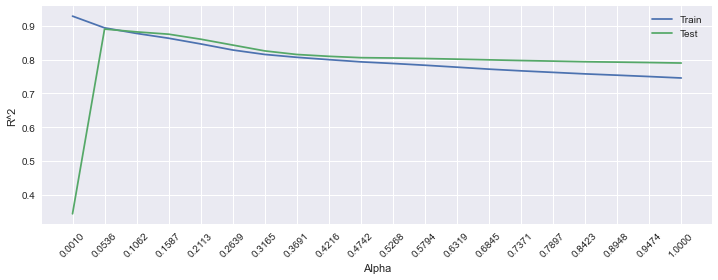

In [15]:
#Создаём список из 20 возможных значений от 0.001 до 1
alpha_list = np.linspace(0.001, 1, 20)
#Создаём пустые списки, в которые будем добавлять результаты 
train_scores = []
test_scores = []
for alpha in alpha_list:
    #Создаём объект класса линейной регрессии с L1-регуляризацией
    lasso_lr_poly = linear_model.Lasso(alpha=alpha, max_iter=10000)
    #Обучаем модель
    lasso_lr_poly.fit(X_train_scaled_poly, y_train)
    #Делаем предсказание для тренировочной выборки
    y_train_predict_poly = lasso_lr_poly.predict(X_train_scaled_poly)
    #Делаем предсказание для тестовой выборки
    y_test_predict_poly = lasso_lr_poly.predict(X_test_scaled_poly)
    #Рассчитываем коэффициенты детерминации для двух выборок и добавляем их в списки
    train_scores.append(metrics.r2_score(y_train, y_train_predict_poly))
    test_scores.append(metrics.r2_score(y_test, y_test_predict_poly))

#Визуализируем изменение R^2 в зависимости от alpha
fig, ax = plt.subplots(figsize=(12, 4)) #фигура + координатная плоскость
ax.plot(alpha_list, train_scores, label='Train') #линейный график для тренировочной выборки
ax.plot(alpha_list, test_scores, label='Test') #линейный график для тестовой выборки
ax.set_xlabel('Alpha') #название оси абсцисс
ax.set_ylabel('R^2') #название оси ординат
ax.set_xticks(alpha_list) #метки по оси абсцисс
ax.xaxis.set_tick_params(rotation=45) #поворот меток на оси абсцисс
ax.legend(); #отображение легенды


С помощью графика мы можем подобрать оптимальное значение параметра alpha. Нам нужна такая точка на оси абсцисс, при которой на тестовой выборке наблюдается максимальная метрика и при этом разница между метриками на тренировочной и тестовой выборках минимальна.

Видно, что R^2 на тестовой выборке достигает наибольшего значения в точке 0.0536. Причём в этой точке наблюдается примерное равенство метрик на каждом наборе данных. Далее метрика на тестовой выборке начинает падать.

Обратите внимание, что на тренировочной выборке R^2 непрерывно падает с ростом alpha. Оно и понятно, ведь чем больше alpha, тем сильнее регуляризация и тем меньше модель подстраивается под обучающую выборку.

Давайте подставим значение alpha=0.0536 в модель Lasso и получим результат:

In [16]:
#Создаём объект класса линейной регрессии с L1-регуляризацией
lasso_lr_poly = linear_model.Lasso(alpha=0.0536)
#Обучаем модель 
lasso_lr_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = lasso_lr_poly.predict(X_train_scaled_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly = lasso_lr_poly.predict(X_test_scaled_poly)
#Рассчитываем коэффициент детерминации для двух выборок
print("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_train_predict_poly)))
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_test_predict_poly)))

Train R^2: 0.894
Test R^2: 0.890


Примечание. Помимо основных методов регуляризации L1 и L2, существует комплексный метод.

**Эластичная сетка (Elastic Net)** — это комбинация из двух методов регуляризации. Функция потерь в таком методе выглядит следующим образом:

![](data\f59.png)

В sklearn реализация эластичной сетки находится в объекте класса [**ElasticNet**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html).

Параметры ***α*** и ***λ*** позволяют регулировать вклад L1- и L2-регуляризации. На практике данный метод используется гораздо реже, так как нужно подбирать оптимальную комбинацию из двух параметров.

Примечание. Регуляризация присутствует и в модели SGDRegressor, причём она используется по умолчанию. В инициализаторе данного класса есть параметр **penalty**, который позволяет управлять методом регуляризации. Параметр может принимать значения '**l1**', '**l2**' и '**elasticnet**'. По умолчанию используется L2-регуляризация (penalty='l2'). Коэффициент регуляризации (alpha) по умолчанию равен 0.0001 (относительно слабая регуляризация). Управляя двумя этими параметрами, вы можете настраивать тип регуляризации в SGD-методе и её «силу».